In [1]:
%pip install dask_ml


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.5/148.5 KB 1.4 MB/s eta 0:00:00


In [16]:

import dask.dataframe as dd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from dask_ml.decomposition import IncrementalPCA
import dask.array as da
import pandas as pd
from urllib.request import urlretrieve
import zipfile
import matplotlib.pyplot as plt

In [3]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-25m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()


Done.


Using Dask to retrieve data from ratings.csv file . Storing the result in dask dataframe

In [5]:
ratings_dd = dd.read_csv('ml-25m/ratings.csv')

Time taken (Dask): 0.015988588333129883 seconds


In [9]:
ratings_df=ratings_dd.compute()
ratings_df=ratings_df.head(500000)

In [10]:
# Group by user ID and keep only users who have rated at least 10 movies
grouped_ratings = ratings_df.groupby('userId').filter(lambda x: len(x) >= 10)
# Pivot the table
ratings_pivot = grouped_ratings.pivot(index='userId', columns='movieId', values='rating')

In [11]:
# Normalize the ratings by subtracting the mean rating for each user
user_means = ratings_pivot.mean(axis=1)
ratings_pivot = ratings_pivot.sub(user_means, axis=0)
ratings_pivot=ratings_pivot.fillna(0)


In [13]:
pca = PCA(n_components=2)
ratings_pca = pca.fit_transform(ratings_pivot)

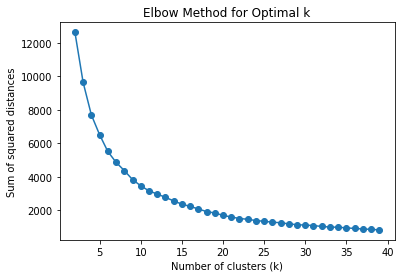

In [20]:
k_values = range(2, 40)
sse_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(ratings_pca)
    sse = kmeans.inertia_
    sse_values.append(sse)

# Plot the sum of squared distances for each value of k
plt.plot(k_values, sse_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [15]:
# Calculate pairwise cosine similarities between users
cosine_similarities = cosine_similarity(ratings_pca)
k=15
kmeans = KMeans(n_clusters=k, random_state=0).fit(cosine_similarities)

user_clusters = kmeans.labels_

Computing the cosine similarity between the users in each cluster by taking the dot product of the cluster centroids (representing the average ratings of the users in the cluster) and normalizing by the product of their magnitudes

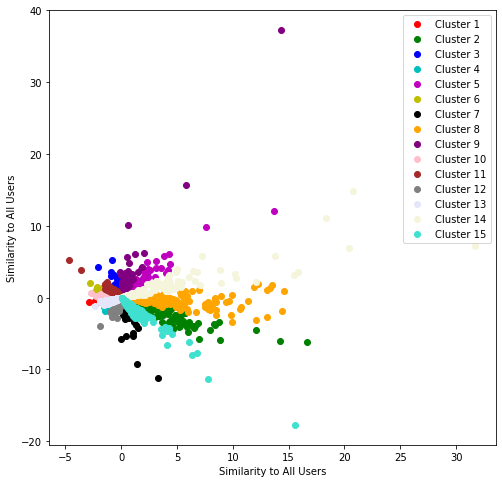

In [17]:
# Define a list of colors to use for each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 
          'orange', 'purple', 'pink', 'brown', 'grey', 
          'lavender', 'beige', 'turquoise']

# Create a scatter plot of all the data points in the similarity matrix
plt.figure(figsize=(8, 8))

# Loop through each cluster
for i in range(k):
    # Get the indices of the users in the current cluster
    indices = np.where(user_clusters == i)[0]
    
    # Get the values of the similarity matrix for the current users
    x = ratings_pca[indices, :]
    
    # Plot the points for the current cluster with the corresponding color
    plt.scatter(x[:, 0], x[:, 1], c=colors[i], label=f"Cluster {i+1}")

# Add labels to the plot
plt.xlabel("Similarity to All Users")
plt.ylabel("Similarity to All Users")
plt.legend()
plt.show()


In [18]:
# Get the cluster labels for each user

# Print the number of users in each cluster
for i in range(k):
    print(f"Cluster {i+1}: {np.sum(user_clusters == i)} users")

Cluster 1: 568 users
Cluster 2: 183 users
Cluster 3: 96 users
Cluster 4: 143 users
Cluster 5: 112 users
Cluster 6: 344 users
Cluster 7: 115 users
Cluster 8: 198 users
Cluster 9: 100 users
Cluster 10: 753 users
Cluster 11: 171 users
Cluster 12: 119 users
Cluster 13: 274 users
Cluster 14: 130 users
Cluster 15: 139 users


In [19]:
# Find the users that are most similar to a given user

target_user_id = 3  # Example target user ID
target_user_id=int(target_user_id)
target_user_cluster = user_clusters[target_user_id]

cluster_users = np.where(user_clusters == target_user_cluster)[0]
similar_users = []

for user_id in cluster_users:
    if user_id != target_user_id:
        similarity = cosine_similarities[target_user_id][user_id]
        similar_users.append((user_id, similarity))

# Sort the similar users by decreasing similarity
similar_users = sorted(similar_users, key=lambda x: x[1], reverse=True)

# Print the top 10 similar users
for user in similar_users[:10]:
    print('User ID:', user[0])

Enter UserId2
User ID: 2376
User ID: 676
User ID: 2239
User ID: 1480
User ID: 2316
User ID: 1865
User ID: 1120
User ID: 1997
User ID: 2782
User ID: 2724


In [ ]:
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['userId','similaruserid_1','similaruserid_2','similaruserid_3','similaruserid_4','similaruserid_5','similaruserid_6','similaruserid_7','similaruserid_8','similaruserid_9','similaruserid_10'])

# Loop through all user IDs
for user_id in range(1, 2001):
    target_user_cluster = user_clusters[user_id]
    cluster_users = np.where(user_clusters == target_user_cluster)[0]
    similar_users = []
    for other_user_id in cluster_users:
        if other_user_id != user_id:
            similarity = cosine_similarities[user_id][other_user_id]
            similar_users.append((other_user_id, similarity))
    # Sort the similar users by decreasing similarity and get the top 10
    similar_users = sorted(similar_users, key=lambda x: x[1], reverse=True)[:10]
    # Add the results to the DataFrame
    result = [user_id] + [tup[0] for tup in similar_users]
    results_df.loc[len(results_df)] = result

# Save the results to a CSV file
results_df.to_csv('similar_users.csv', index=False)
